In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [ ]:
from scipy.stats import randint, zscore
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    VotingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    IsolationForest,
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
dfTrain = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Shai/Task7/train.csv"))

First step: Exploring Data

In [ ]:
dfTrain.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [ ]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
dfTrain.isna().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [ ]:
dfTrain.describe(include="all")

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152,43152,43152,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,17203,9060,10428,NaN,NaN,NaN,NaN,NaN,NaN
mean,21576.500000,0.797855,NaN,NaN,NaN,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,NaN,NaN,NaN,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,NaN,NaN,NaN,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,NaN,NaN,NaN,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000


In [ ]:
dfTrain.loc[~(dfTrain == 0).all(axis=1)]

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...,...,...
43147,43148,0.52,Ideal,E,VS2,61.5,56.0,1760,5.16,5.18,3.18
43148,43149,0.72,Very Good,D,VS2,62.1,59.0,3016,5.70,5.73,3.55
43149,43150,0.44,Premium,I,VVS1,61.5,58.0,990,4.95,4.87,3.02
43150,43151,0.31,Premium,E,VS1,60.2,58.0,734,4.38,4.43,2.65


In [ ]:
dfTrain["cut"].value_counts()

cut
Ideal        17203
Premium      11113
Very Good     9658
Good          3881
Fair          1297
Name: count, dtype: int64

In [ ]:
dfTrain["color"].value_counts()

color
G    9060
E    7832
F    7633
H    6651
D    5421
I    4265
J    2290
Name: count, dtype: int64

In [ ]:
dfTrain["clarity"].value_counts()

clarity
SI1     10428
VS2      9824
SI2      7432
VS1      6475
VVS2     4041
VVS1     2904
IF       1442
I1        606
Name: count, dtype: int64

Findings:
1) There's a total of 9 features, 3 categorical (cut, color, clarity), and 6 numerical (carat, depth, table, x, y, z), in addition to Id column which is irrelevant and price   which is our target.
1) Alla categorial features have definite values that have an ordinal order, so they're all good candidates for OrdinalEncoder.
2) There's no null values, however there's some values that are unrealistically zero, and as they can just be removed from our data due to their negligible amount.

Second Step: Data visualisation

<Axes: >

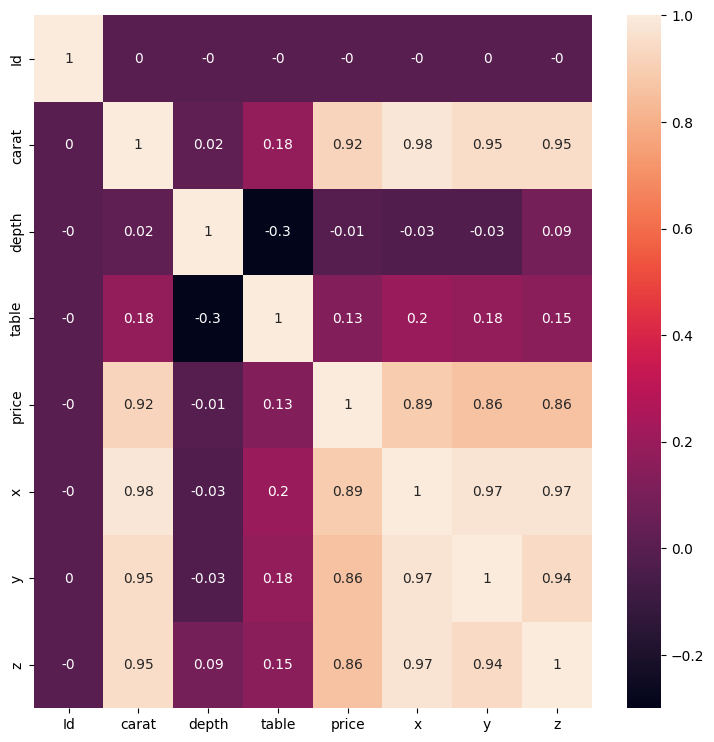

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(dfTrain.select_dtypes("number").corr().round(2), annot=True)

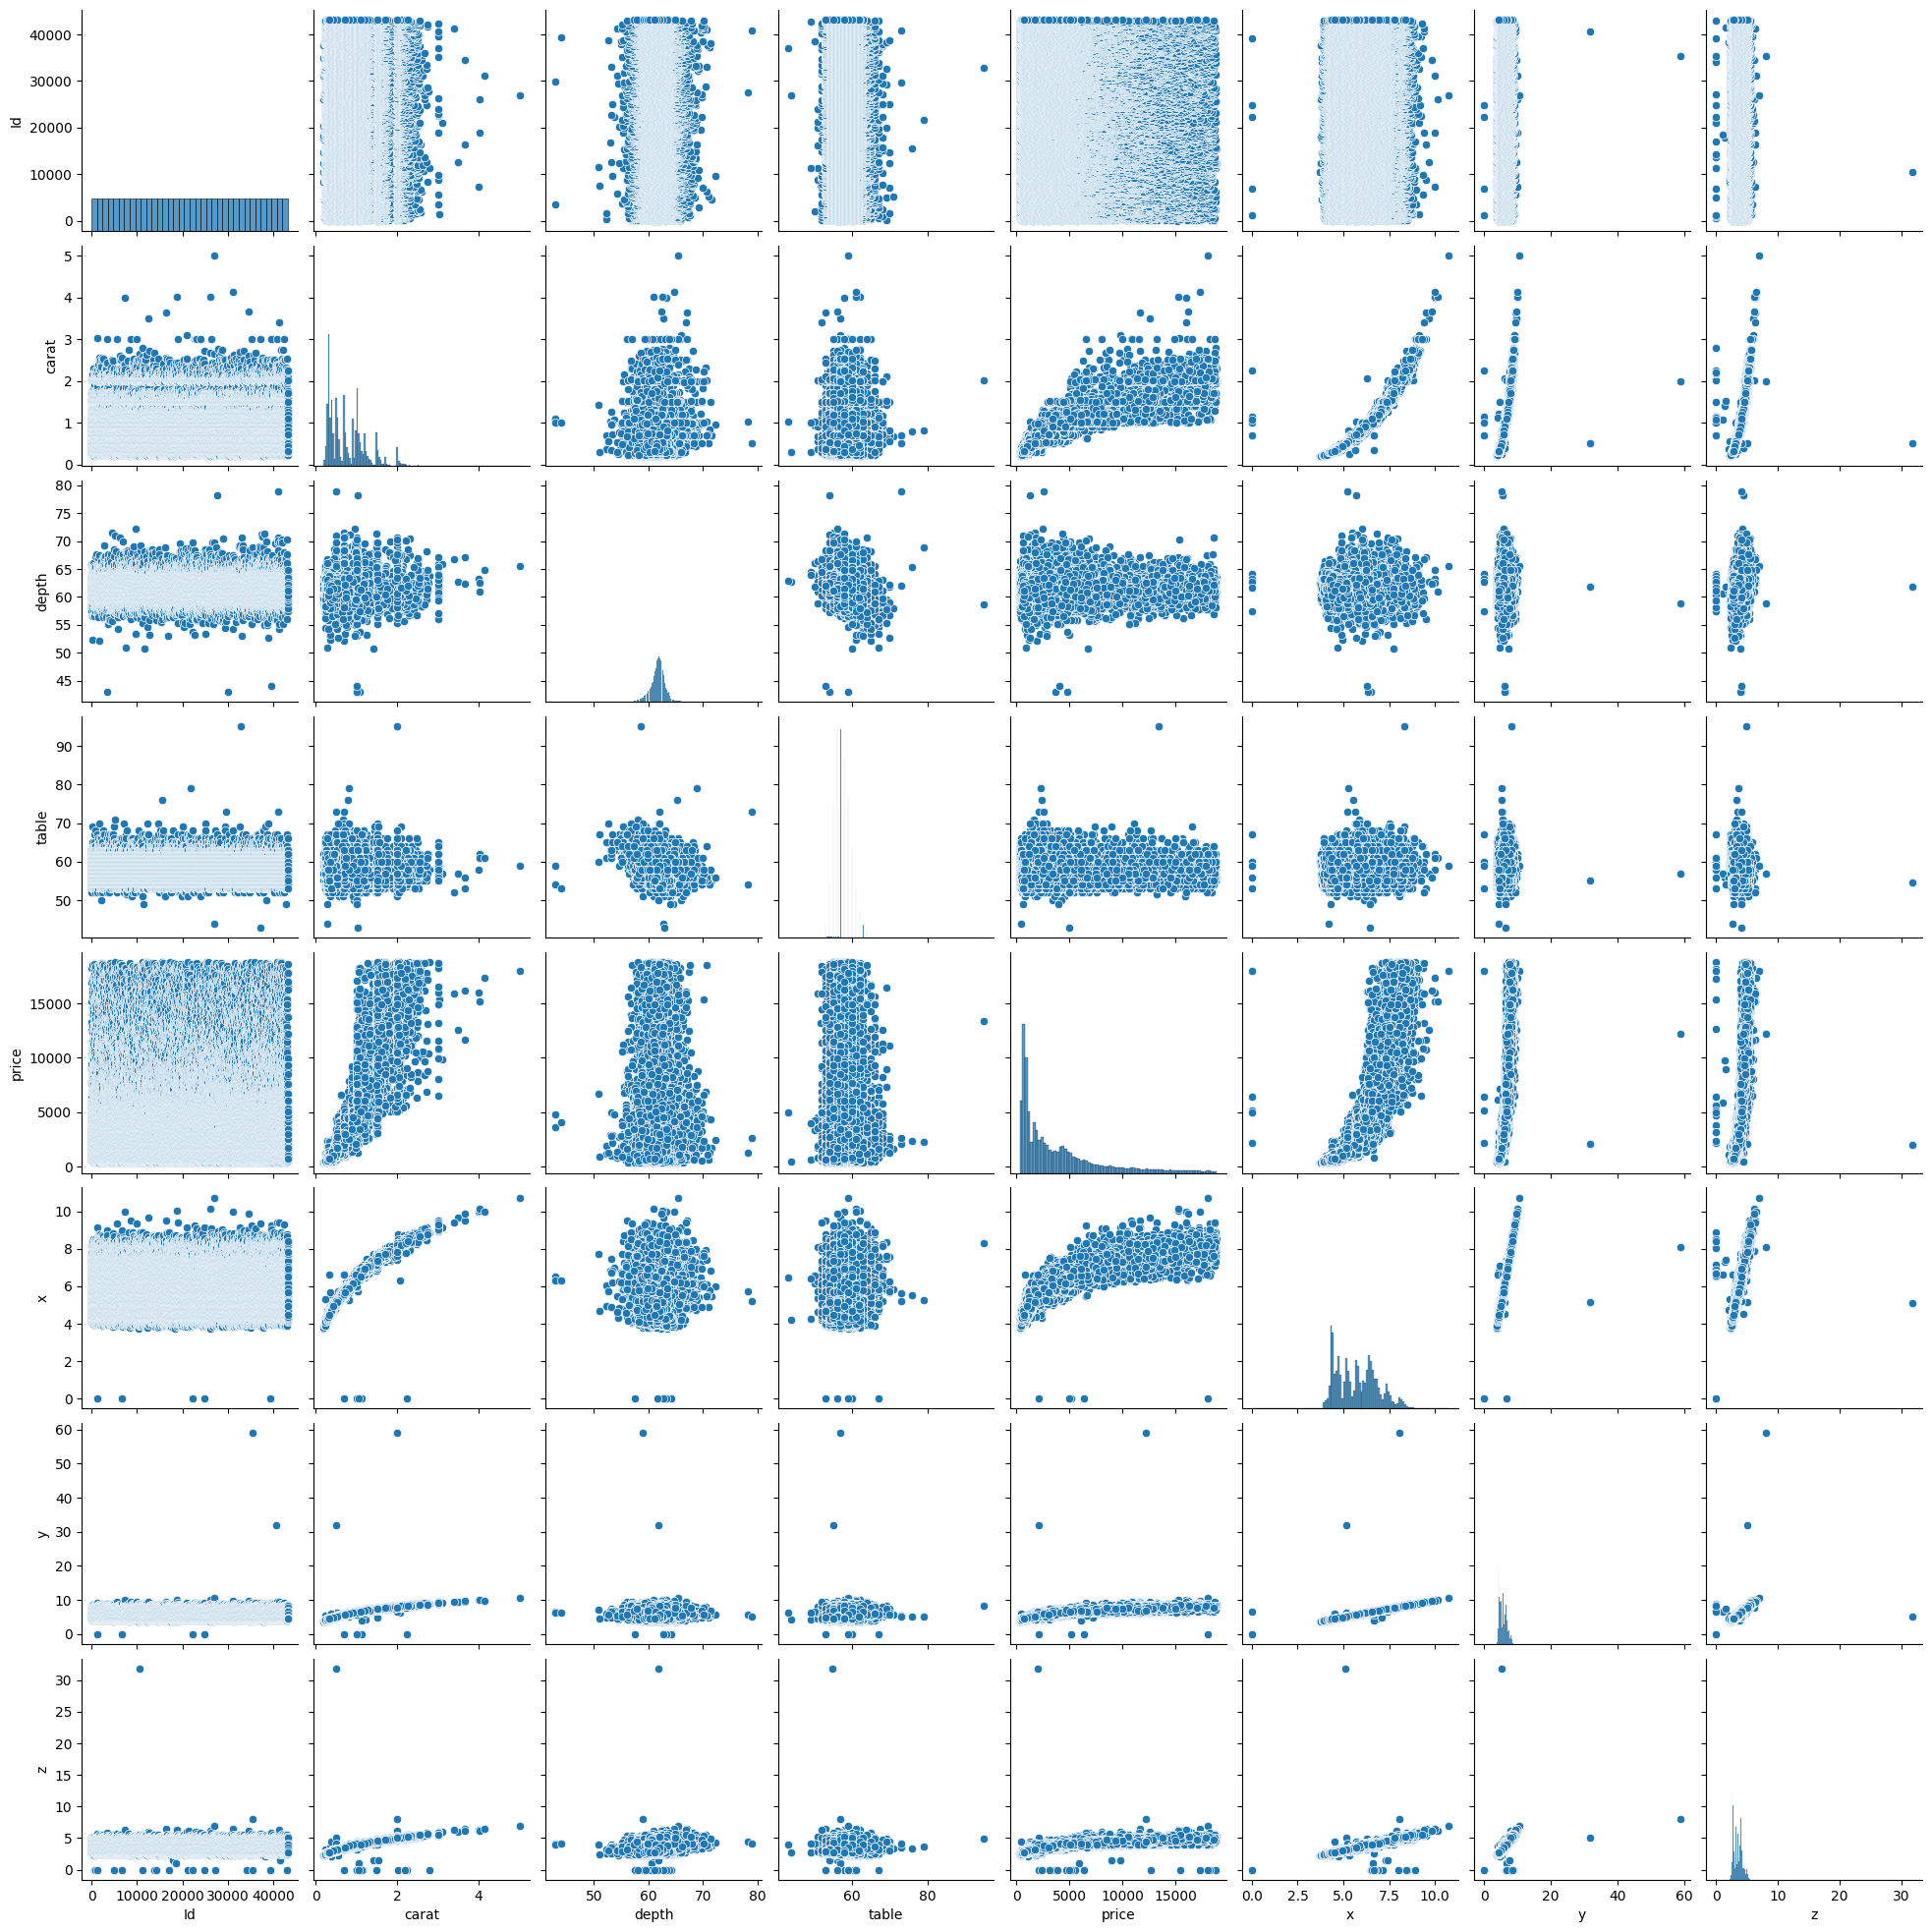

In [ ]:
sns.pairplot(dfTrain.select_dtypes("number"))

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>],
       [<Axes: title={'center': 'table'}>,
        <Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y'}>, <Axes: title={'center': 'z'}>,
        <Axes: >]], dtype=object)

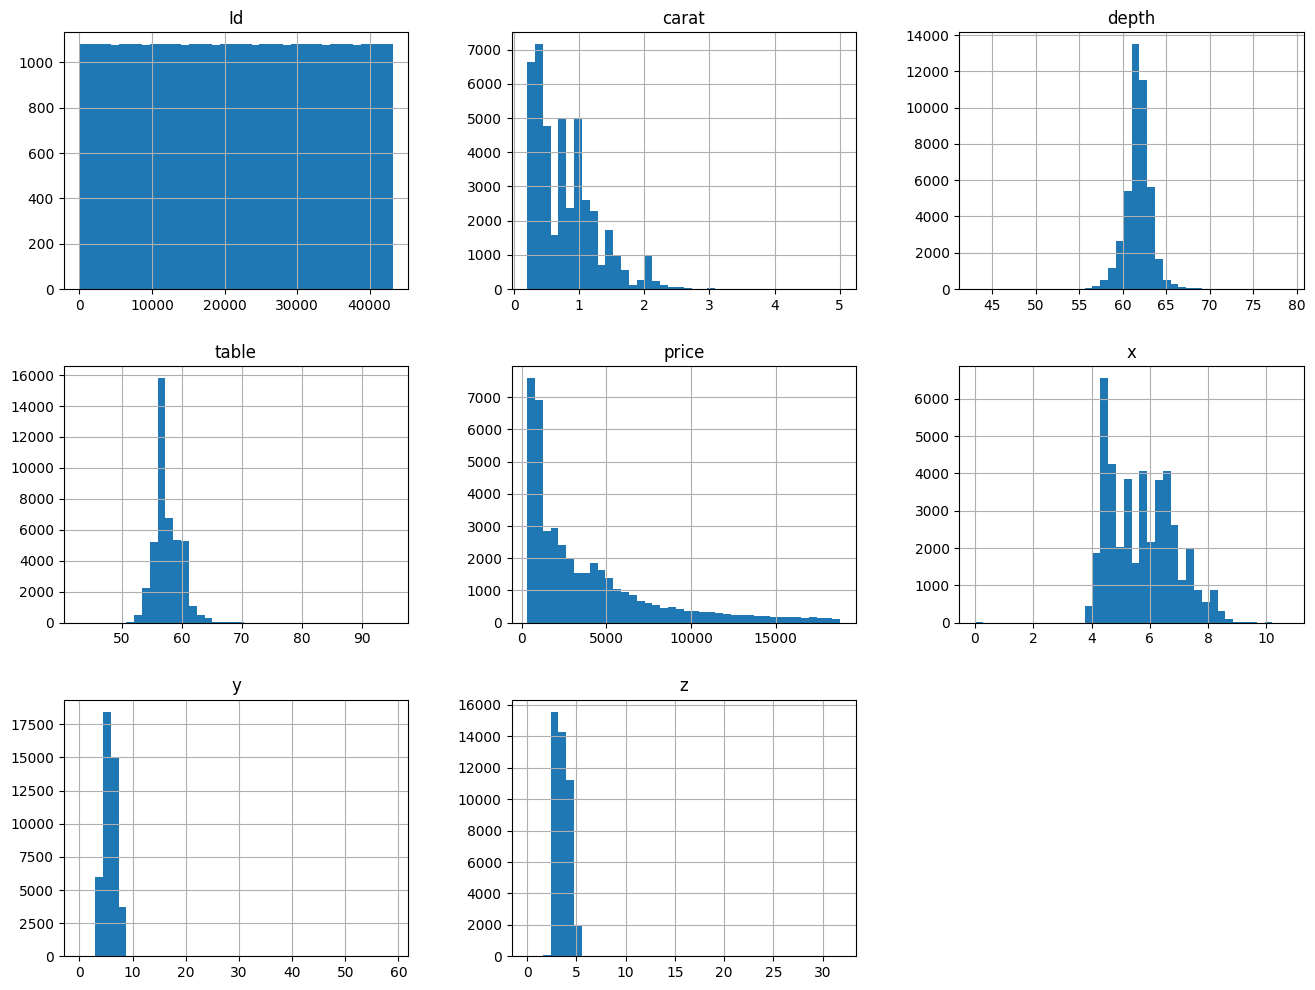

In [ ]:
dfTrain.hist(figsize=(16, 12), bins=40)

<Axes: xlabel='carat', ylabel='price'>

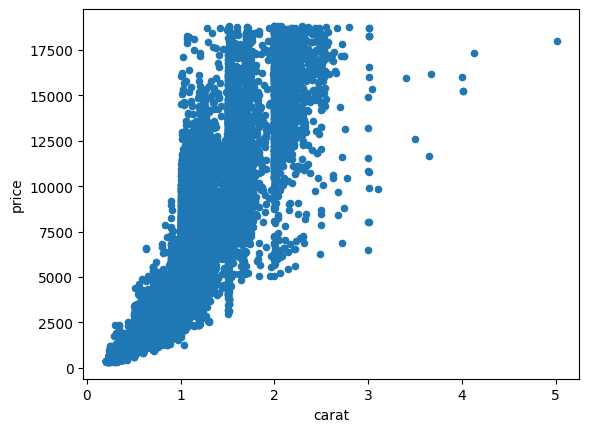

In [ ]:
dfTrain.plot(kind="scatter", x="carat", y="price")

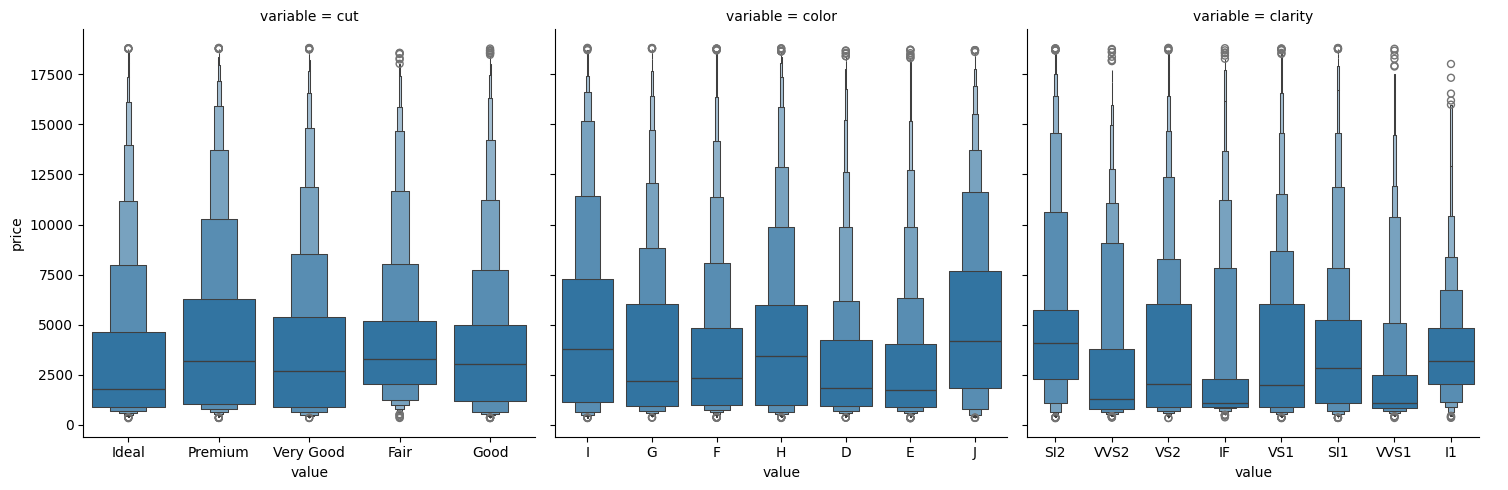

In [ ]:
sns.catplot(
    x="value",
    y="price",
    col="variable",
    sharex=False,
    kind="boxen",
    data=dfTrain.melt(id_vars="price", value_vars=["cut", "color", "clarity"]),
)

In [ ]:
xTrain = dfTrain.copy()
yTrain = xTrain.pop("price")
pd.Series(
    mutual_info_regression(X=xTrain.select_dtypes("number"), y=yTrain, random_state=42),
    index=xTrain.select_dtypes("number").columns,
)

Id       0.006577
carat    1.927467
depth    0.034878
table    0.054615
x        1.468393
y        1.466473
z        1.420348
dtype: float64

In [ ]:
kMeans = KMeans(n_clusters=5, random_state=42)

dfTrain["cluster"] = kMeans.fit_predict(dfTrain[["carat"]])
dfTrain["cluster"] = dfTrain["cluster"].astype("str")

pd.DataFrame(
    kMeans.cluster_centers_,
    index=kMeans.get_feature_names_out(),
    columns=["clusterCenter"],
).sort_values("clusterCenter")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,clusterCenter
kmeans1,0.344239
kmeans3,0.632909
kmeans2,1.051255
kmeans0,1.522456
kmeans4,2.121459


<Axes: xlabel='carat', ylabel='Count'>

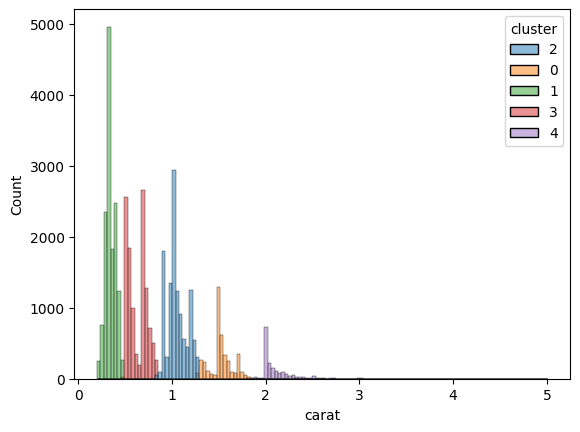

In [ ]:
sns.histplot(data=dfTrain, x="carat", hue="cluster")

In [ ]:
dfTrain["cluster"].value_counts()

cluster
1    14127
2    11803
3    11401
0     4018
4     1803
Name: count, dtype: int64

Findings:
1) A strong linear correlation exists between our target and (carat, x, y, z which are in turn all strongly correlated)
2) Price both show a distribution with a long tail and can be tried to be replaced by their logarithm
3) mutual_info_regression shows no difference in relation between features from correlation
4) Distribution plot of carat shows many peaks and can be clustered

Third Step : Feature engineering

In [ ]:
dfTrain = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Shai/Task7/train.csv"))
dfTest = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Shai/Task7/test.csv"))

In [ ]:
# Removing 0 containing rows
dfTrain = dfTrain[~(dfTrain == 0).any(axis=1)]

In [ ]:
# Adding calculated fields (replace x & y with x/y ration which in my point of view is more representative to the shape of the diamond which I assume it affects the price)
for df in [dfTrain, dfTest]:
    df["xyRatio"] = df["x"] / df["y"]

# Transforming our target feature into its log
dfTrain['price'] = np.log(dfTrain['price'])

<ipython-input-32-e72fe3f3158e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["xyRatio"] = df["x"] / df["y"]
<ipython-input-32-e72fe3f3158e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrain['price'] = np.log(dfTrain['price'])


In [ ]:
# Clustering carat
kMeans = KMeans(n_clusters=5, random_state=42)
dfTrain["cluster"] = kMeans.fit_predict(dfTrain[["carat"]])
dfTest["cluster"] = kMeans.predict(dfTest[["carat"]])

dfTrain["cluster"] = dfTrain["cluster"].astype("str")
dfTest["cluster"] = dfTest["cluster"].astype("str")

clusterOrder = [
    cluster.removeprefix("kmeans")
    for cluster in list(
        pd.DataFrame(
            kMeans.cluster_centers_,
            index=kMeans.get_feature_names_out(),
            columns=["clusterCenter"],
        )
        .sort_values("clusterCenter")
        .index
    )
]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Removing Outliers for features that showed a normal distribution
isolationForest = IsolationForest(contamination=0.001, random_state= 42)
indexToRemove = []
for feat in ['depth', 'table']:
  outliers = pd.Series(isolationForest.fit_predict(dfTrain[[feat]]))
  outliersIndex = list(outliers[outliers == -1].index)
  indexToRemove += outliersIndex

for cluster in list(dfTest['cluster'].unique()):
  dfTrainCluster = dfTrain[dfTrain['cluster']==cluster]
  outliers = pd.Series(isolationForest.fit_predict(dfTrainCluster[['carat']]))
  outliersIndex = list(outliers[outliers == -1].index)
  indexToRemove += outliersIndex

dfTrain = dfTrain.drop(set(indexToRemove))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

Fourth Step: Model Training

In [ ]:
# Prepare train splits
xTrain = dfTrain.copy()
yTrain = xTrain.pop("price")

In [ ]:
# Main Pipeline
numCol = ["carat", "depth", "table", "z", "xyRatio"]

numPipeline = Pipeline([
    ("imputerNumNan", SimpleImputer(strategy="mean")),
    ("imputerNumZero", SimpleImputer(missing_values=0, strategy="mean")),
    ("standardizerNum", StandardScaler()),
    ])
cutPipeline = Pipeline([
    ("imputerCutNan", SimpleImputer(strategy="most_frequent")),
    ("imputerCutZero", SimpleImputer(missing_values=0, strategy="most_frequent")),
    ("ordinalEncoderCut", OrdinalEncoder(categories=[["Fair", "Good", "Very Good", "Premium", "Ideal"]])),
    ])
colorPipeline = Pipeline([
    ("imputerColorNan", SimpleImputer(strategy="most_frequent")),
    ("imputerColorZero", SimpleImputer(missing_values=0, strategy="most_frequent")),
    ("ordinalEncoderCut", OrdinalEncoder(categories=[["J", "I", "H", "G", "F", "E", "D"]])),
    ])
clarityPipeline = Pipeline([
    ("imputerClarityNan", SimpleImputer(strategy="most_frequent")),
    ("imputerClarityZero", SimpleImputer(missing_values=0, strategy="most_frequent")),
    ("ordinalEncoderCut", OrdinalEncoder(categories=[["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]])),
    ])
clusterPipeline = Pipeline([
    ("ordinalEncoderCluster", OrdinalEncoder(categories=[clusterOrder])),
    ])
fullPipeline = ColumnTransformer([
    ("numPipeline", numPipeline, numCol),
    ("cutPipeline", cutPipeline, ["cut"]),
    ("colorPipeline", colorPipeline, ["color"]),
    ("clarityPipeline", clarityPipeline, ["clarity"]),
    ("clusterPipeline", clusterPipeline, ["cluster"]),
    ])

Findings:

1) After trying many regressor, Many promising ones showed up such as:

[LGBMRegressor, ExtraTreesRegressor, CatBoostRegressor, HistGradientBoostingRegressor, RandomForestRegressor,
XGBRegressor, BaggingRegressor]

2) A VotingRegressor is trained with all previous models after optimizing them individually using (RandomizedSearchCV, GridSearchCV)

In [ ]:
# Models Implementation
lGBMRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("lGBMRegModel",LGBMRegressor(random_state=42, n_jobs=-1, boosting_type="gbdt", max_depth=50, num_leaves=47, max_bin=665, num_iterations=131))])

exTreesRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("exTreesRegModel", ExtraTreesRegressor(random_state= 42, n_estimators=450, n_jobs=-1, min_samples_split=7, min_samples_leaf=4, max_depth=44))])

histGradBooRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("histGradBooRegModel", HistGradientBoostingRegressor(random_state= 42, max_depth= 12, max_leaf_nodes= 61, min_samples_leaf= 14))])

ranForRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("ranForRegModel", RandomForestRegressor(random_state= 42, max_depth = 14, n_estimators= 700))])

xgboostModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("xgboostModel", XGBRegressor(max_depth= 5, reg_alpha= 88, reg_lambda= .7, colsample_bytree= .9, min_child_weight= 3))])

bagRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("bagRegModel", BaggingRegressor(random_state=42, n_estimators=43))])

catBoRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("catBoRegModel", CatBoostRegressor(random_state=42))])

votRegModel = VotingRegressor(
    estimators=[
        ("ranForRegModel", ranForRegModel),
        ("xgboostModel", xgboostModel),
        ("bagRegModel", bagRegModel),
        ("exTreesRegModel", exTreesRegModel),
        ("histGradBooRegModel", histGradBooRegModel),
        ("lGBMRegModel", lGBMRegModel),
        ("catBoRegModel", catBoRegModel),
    ], n_jobs=3)

votRegModel = VotingRegressor(
    estimators=[
        ("ranForRegModel", ranForRegModel),
        ("xgboostModel", xgboostModel),
        ("bagRegModel", bagRegModel),
        ("exTreesRegModel", exTreesRegModel),
        ("histGradBooRegModel", histGradBooRegModel),
        ("lGBMRegModel", lGBMRegModel),
        ("catBoRegModel", catBoRegModel),
    ], n_jobs=3)

In [ ]:
votRegModel.fit(X=xTrain, y=yTrain)
scores = cross_val_score(estimator=votRegModel, X=xTrain, y=yTrain, scoring="neg_root_mean_squared_error", cv=10)
print(pd.DataFrame(scores).describe().transpose().round(2))

train_data_predictions = votRegModel.predict(xTrain)
mse = mean_squared_error(train_data_predictions, yTrain, squared=False)
print(mse)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Cu

In [ ]:
ID=dfTest['Id']
price=votRegModel.predict(dfTest.drop('Id',axis=1))
data={'ID':ID,'price':np.exp(price)}
sub=pd.DataFrame(data)
sub.to_csv('sub.csv',index=False)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
